## Pre-process data provided by Arasumani et al. 

In [7]:
### landcover classes
landcover_classes = {
    1: "Phalaris",
    2: "Typha",
    3: "Phragmites",
    4: "Shrublands",
    5: "Forest",
    6: "Non-wet grasslands",
    7: "Settlements",
    8: "Croplands",
    9: "Water bodies",
    10: "Wet grasslands",
    11: "Carex"
}


## Rasterize Aviris Classification Layer

In [4]:
# Load the necessary libraries
import os
import random
from shapely.geometry import Point
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import gdal, ogr, osr
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter
from skimage import morphology, filters, measure
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import geopandas as gpd

gdal.DontUseExceptions()

##### To access the AVIRIS-NG based classification map created by Arasumani et al. (2023) please contact the authors or use your own classification map.

In [8]:
#### rasterize with rasterio because with gdal somehow it does not work

# File paths
vector_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/aviris_classification.gpkg'
output_raster_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/aviris_classification_3035.tif'

# Step 2: Load and reproject the vector file to match the raster CRS
vector_data = gpd.read_file(vector_path)
vector_data = vector_data.to_crs(epsg=3035)

# Step 3: Calculate the raster extent and resolution (5.8m)
vector_bounds = vector_data.total_bounds  # (minx, miny, maxx, maxy)
resolution = 5.8  # Desired resolution in meters

# Ensure dimensions align with the resolution
width = int((vector_bounds[2] - vector_bounds[0]) / resolution)
height = int((vector_bounds[3] - vector_bounds[1]) / resolution)

# Create the new transform
transform = from_origin(vector_bounds[0], vector_bounds[3], resolution, resolution)

# Step 4: Prepare the shapes for rasterization
# Use the `gridcode` attribute as the burn value for each geometry
shapes = [
    (geom, row.gridcode) for geom, row in zip(vector_data.geometry, vector_data.itertuples())
]

# Create an empty raster array with the same dimensions as calculated
out_raster = np.zeros((height, width), dtype=np.uint8)

# Rasterize the vector geometries
rasterized = rasterize(
    shapes=shapes,
    out=out_raster,
    transform=transform,
    fill=0,  # Background value
    dtype="uint8"
)

# Step 5: Save the rasterized output with the raster's CRS
with rasterio.open(
    output_raster_path,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="uint8",
    crs="EPSG:3035",
    transform=transform,
) as dst:
    dst.write(rasterized, 1)

print(f"Rasterized vector saved to {output_raster_path}")


Rasterized vector saved to /Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/aviris_classification_3035.tif


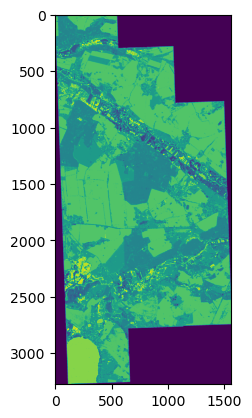

In [9]:
# plot the reprojected raster
raster = gdal.Open(output_raster_path)
band = raster.GetRasterBand(1)
array = band.ReadAsArray()
plt.imshow(array)
plt.show()


## Create Homogenous Raster

In [10]:
# Function to check homogeneity in a 3x3 window
def check_homogeneity(window):
    # Check if all values in the window are the same
    if np.all(window == window[4]):
        return window[4]
    return 0

# Get homogenous reference sample locations
def homogenous_regions(input_rast, output_rast):

    """
    Extracts homogenous regions from a raster.
    input_rast: string
        Path to the input raster.
    output_rast: string 
        Path to the output raster.
    """

    # Open the raster
    raster = gdal.Open(input_rast)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()

    # filter for homogenous areas
    output_array = generic_filter(array, check_homogeneity, size=(3, 3), mode='constant', cval=-9999)

    # create new raster 
    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(
        output_rast,
        raster.RasterXSize,
        raster.RasterYSize,
        1,
        band.DataType)

    out_raster.SetGeoTransform(raster.GetGeoTransform())
    out_raster.SetProjection(raster.GetProjection())

    out_band = out_raster.GetRasterBand(1)
    out_band.WriteArray(output_array)
    out_band.SetNoDataValue(-9999)

    # Clean up
    band = None
    raster = None
    out_band = None
    out_raster = None

    return output_rast


In [11]:
## create homogenous raster
# define variables
input_rast = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/aviris_classification_3035.tif'
output_rast = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/homogenous_regions.tif'

# use function
homogenous_regions(input_rast, output_rast)


'/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/homogenous_regions.tif'

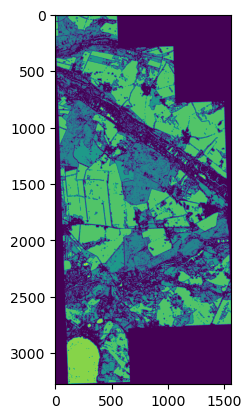

In [12]:
# plot the reprojected raster
raster = gdal.Open('/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/homogenous_regions.tif')
band = raster.GetRasterBand(1)
array = band.ReadAsArray()
plt.imshow(array)
plt.show()

In [13]:
# Open the raster and count unique values
raster = gdal.Open(output_rast)
band = raster.GetRasterBand(1)
array = band.ReadAsArray()
uniue_values = np.unique(array, return_counts=True)
print(uniue_values)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint8), array([2677755,    3222,    6687,   20897,   13886,  474994,  375721,
          1819, 1391813,  131202,   16340,    4338]))


## Sample homogenous landcover point locations

In [14]:
def sample_random_points(homogeneous_rast, n_samples):
    """
    Sample random points equally distributed over the land cover classes.
    
    Parameters:
    homogeneous_rast (str): Path to the homogeneous raster.
    n_samples (int): Number of points to sample per land cover class.
    
    Returns:
    pd.DataFrame: DataFrame containing the sampled points with columns ['x', 'y', 'class'].
    """
    # Open the homogeneous raster
    raster = gdal.Open(homogeneous_rast)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()

    # Identify unique land cover classes
    unique_classes = np.unique(array)
    unique_classes = unique_classes[unique_classes != -9999]  # Exclude no-data value

    # List to store sampled points
    sampled_points = []

    # Sample points for each class
    for lc_class in unique_classes:
        # Get the indices of pixels belonging to the current class
        class_indices = np.argwhere(array == lc_class)
        
        # Randomly sample points from the class indices
        if len(class_indices) >= n_samples:
            sampled_indices = class_indices[np.random.choice(class_indices.shape[0], n_samples, replace=False)]
        else:
            sampled_indices = class_indices
        
        # Store the sampled points
        for idx in sampled_indices:
            sampled_points.append((idx[1] + 0.5, idx[0] + 0.5, lc_class))  # (x, y, class)

    # Create a DataFrame from the sampled points
    df = pd.DataFrame(sampled_points, columns=['x', 'y', 'class'])
    #df.to_csv('sampled_points.csv', index=False)

    return df

# usage
homogeneous_rast = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/homogenous_regions.tif'
num_points_per_class = 50  
df = sample_random_points(homogeneous_rast, num_points_per_class)
df.head()

,x,y,class
0,1103.5,1896.5,0
1,1030.5,3193.5,0
2,1068.5,522.5,0
3,618.5,910.5,0
4,323.5,824.5,0


In [15]:
np.unique(df['class'], return_counts=True) # check if it worked

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint8),
 array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]))

In [16]:
def convert_to_gpkg(raster_path, df, output_gpkg, crs='EPSG:3035'):
    """
    Convert the sampled points DataFrame to a GeoPackage point layer.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the sampled points with columns ['x', 'y', 'class'].
    output_gpkg (str): Path to the output GeoPackage file.
    crs (str): Coordinate Reference System (default is 'EPSG:3035').
    """
    # Get x and y coordinates for df points
    # Open the raster file
    raster = gdal.Open(raster_path)

    # Get the geotransformation parameters
    geotransform = raster.GetGeoTransform()

    origin_x = geotransform[0]
    origin_y = geotransform[3]
    pixel_width = geotransform[1]
    pixel_height = geotransform[5]

    # Create a GeoDataframe with the coordinates
    df_copy = df.copy()

    # Create a GeoDataFrame from the DataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(origin_x + df_copy.x * pixel_width, origin_y + df_copy.y * pixel_height))
    
    # Set the CRS
    gdf.set_crs(crs, inplace=True)
    
    # Save the GeoDataFrame to a GeoPackage
    gdf.to_file(output_gpkg, layer='sampled_points', driver='GPKG')

raster_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/homogenous_regions.tif'
output_gpkg = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/sample_points/sampled_points.gpkg'
convert_to_gpkg(raster_path, df, output_gpkg)

## Classification Scheme 
### Aggregate Classes
#### At Level 1, I will distinguish peatland vegetation (combined Typha and Phragmites) from the background. At Level 2, I aim to classify finer landcover types, including Typha, Phragmites, shrubs, wet grasslands (P. arundinacea and Carex spp.), water, and a background class.

In [19]:
## Open sampled points
# Define paths
samples = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/sample_points/sampled_points.gpkg'

# Open file
gdf = gpd.read_file(samples)

In [20]:
## Clean file
# Drop class == 0
gdf_copy = gdf.copy()
gdf_copy = gdf_copy[gdf_copy['class'] != 0]

gdf_copy.head()

,x,y,class,geometry
50,613.5,2406.5,1,POINT (4514028.657 3422199.154)
51,1066.5,2508.5,1,POINT (4516656.057 3421607.554)
52,1383.5,2037.5,1,POINT (4518494.657 3424339.354)
53,533.5,970.5,1,POINT (4513564.657 3430527.954)
54,981.5,1138.5,1,POINT (4516163.057 3429553.554)


In [21]:
# add column with class names
### my landcover classes
landcover_classes = {
    1: "Phalaris",
    2: "Typha",
    3: "Phragmites",
    4: "Shrublands",
    5: "Forest",
    6: "Non-wet grasslands",
    7: "Settlements",
    8: "Croplands",
    9: "Water bodies",
    10: "Wet grasslands",
    11: "Carex"
}

gdf_copy['class_name'] = gdf_copy['class'].map(landcover_classes) # love map functions <3
gdf_copy.head()

,x,y,class,geometry,class_name
50,613.5,2406.5,1,POINT (4514028.657 3422199.154),Phalaris
51,1066.5,2508.5,1,POINT (4516656.057 3421607.554),Phalaris
52,1383.5,2037.5,1,POINT (4518494.657 3424339.354),Phalaris
53,533.5,970.5,1,POINT (4513564.657 3430527.954),Phalaris
54,981.5,1138.5,1,POINT (4516163.057 3429553.554),Phalaris


In [22]:
## Create hierarchical classification scheme for the land cover classes
# create two different point datasets: 
# one with where Typha and Phragmites have value 1 and all other classes have value 2
# another where Typha, Phragmites, shrubs, wet grasslands (P. arundinacea and Carex spp.) and water have a separate value and a background class

# Scheme 1
gdf_1 = gdf_copy.copy()

gdf_1['class'] = np.where((gdf_1['class'] == 2) | (gdf_1['class'] == 3), 1, 2)
gdf_1['class_name'] = gdf_1['class'].map({1: 'Typha/Phragmites', 2: 'Other'})
gdf_1.head()


,x,y,class,geometry,class_name
50,613.5,2406.5,2,POINT (4514028.657 3422199.154),Other
51,1066.5,2508.5,2,POINT (4516656.057 3421607.554),Other
52,1383.5,2037.5,2,POINT (4518494.657 3424339.354),Other
53,533.5,970.5,2,POINT (4513564.657 3430527.954),Other
54,981.5,1138.5,2,POINT (4516163.057 3429553.554),Other


In [23]:
#Typha, Phragmites, shrubs, wet grasslands (P. arundinacea and Carex spp.), water, and a background class.
# Scheme 2
gdf_2 = gdf_copy.copy()

gdf_2['class'] = np.where((gdf_2['class'] == 7) | (gdf_2['class'] == 8), 7, gdf_2['class'])
gdf_2['class'] = np.where((gdf_2['class'] == 9) , 8, gdf_2['class'])
gdf_2['class'] = np.where((gdf_2['class'] == 1) | (gdf_2['class'] == 10) | (gdf_2['class'] == 11), 1, gdf_2['class'])
gdf_2['class_name'] = gdf_2['class'].map({1: 'Wet Grassland', 2: 'Typha', 3: 'Phragmites', 4: 'Shrublands', 5: 'Forest', 6: 'Non-wet grasslands', 7: 'Other', 8: 'Water'})


In [24]:
# save both datasets
output_gpkg_1 = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/sample_points/sampled_points_scheme_1.gpkg'
output_gpkg_2 = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/sample_points/sampled_points_scheme_1.gpkg'

gdf_1.to_file(output_gpkg_1, layer='sampled_points', driver='GPKG')
gdf_2.to_file(output_gpkg_2, layer='sampled_points', driver='GPKG')